### Setup des class et des imports

In [ ]:
from src.pdf_io import PDFIo
from src.text_extraction.french_text_cleaner import FrenchTextCleaner
from src.document_vision import DocumentVision
from src.text_extraction.ocr_text_extractor import OCRTextExtractor
from src.document_classifier.classifier_runner import ONNXDocumentClassifier
from src.trainer.document_classifier_classes import DocumentClassifierClasses

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType, FloatTensorType

import joblib

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from onnxruntime import InferenceSession

import numpy as np

In [9]:
io = PDFIo()
doc_vision = DocumentVision()
text_cleaner = FrenchTextCleaner()
text_extractor = OCRTextExtractor(lang="fra+eng")

## 1 - Ouvrir et extraire les pages d'un PDF

Page 1


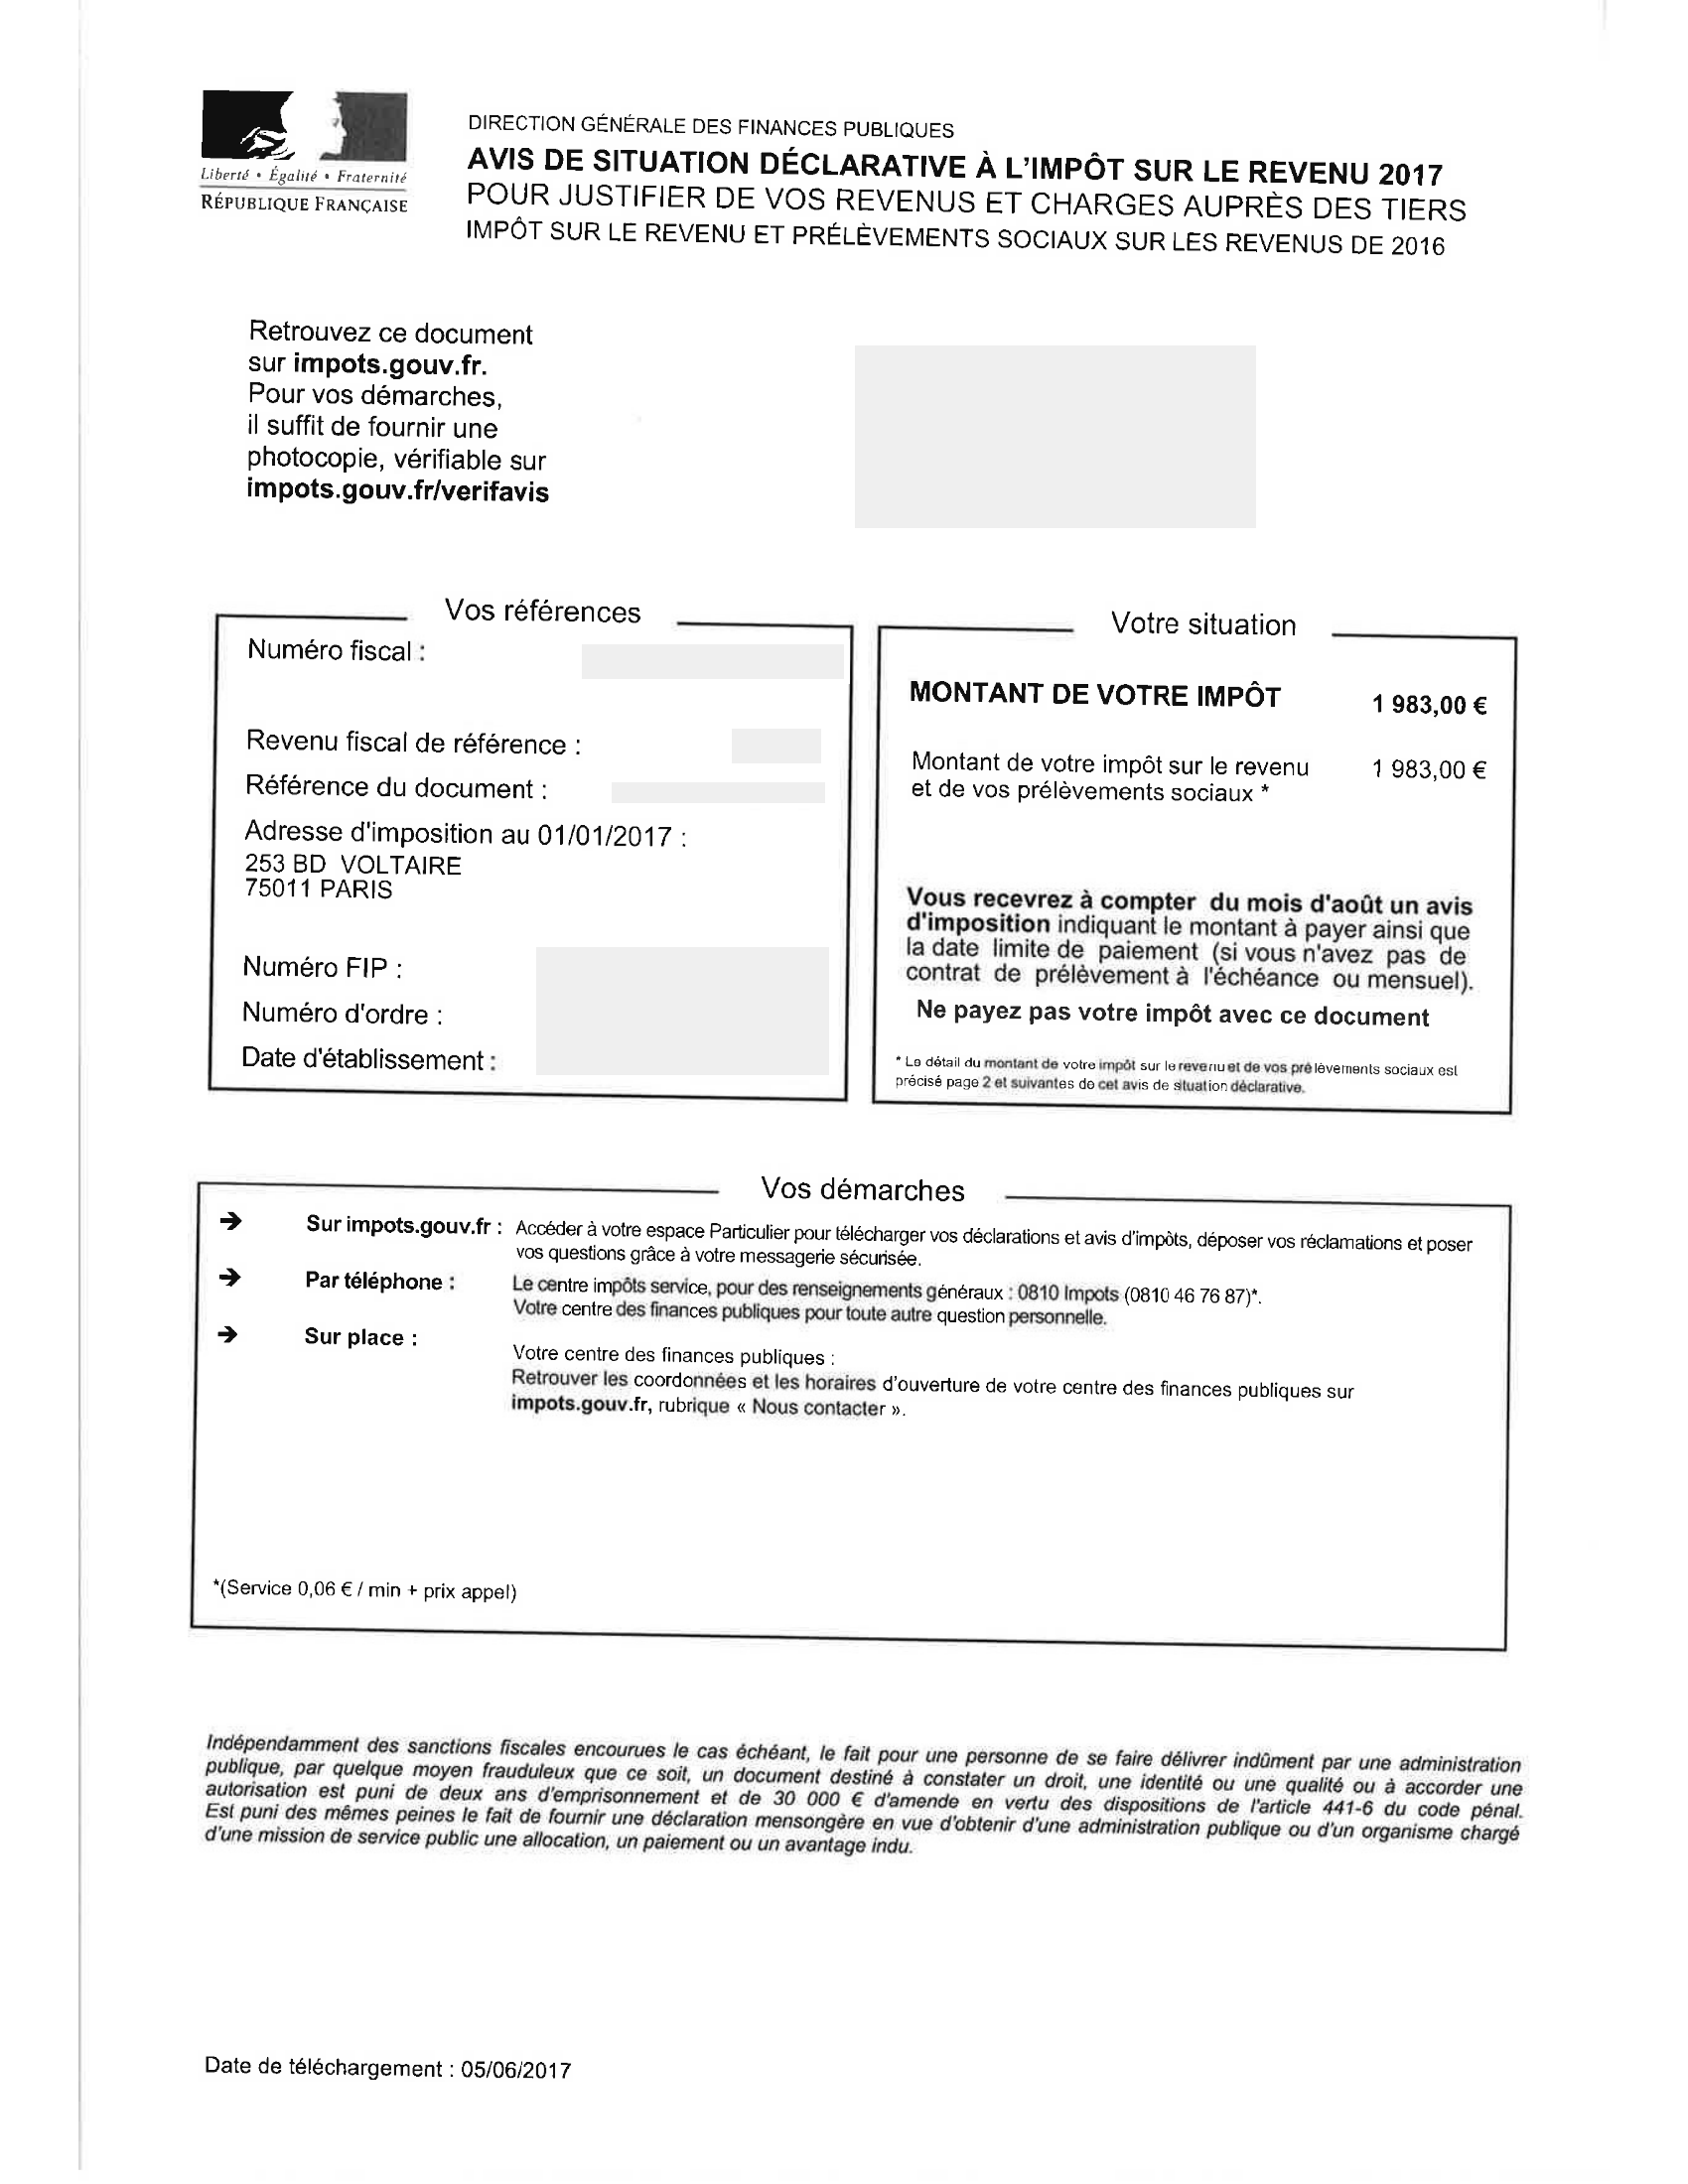

In [ ]:
document_path = 'CNAM/impot-14-rotate_rotated.pdf'

pages = io.load_pages(document_path, auto_rotate=True)
doc_vision.display_page(np.array(pages[0]), title=f"Page 1")

### 3 - Extraire les textes des pages

In [81]:
result_txt = text_extractor.image_to_text(pages[0])
cleaned_text = text_cleaner.clean_text(result_txt)

In [82]:
cleaned_text

'direction centrale finances publiques sent radio femme avis situation déclarative a impôt revenu république français justifier revenus charges autres tiers impôt revenu prélèvements sociaux revenus retrouvez document démarches suffit fournir photocopie vérifiable références situation numéro fiscal montant impôt revenu fiscal référence montant imper revenu référence document prélèvements sociaux adresse disposition bd volontaire paris recevrez a compter mois doit avis disposition indiquant montant a payer ainsi date limite paiement si avez contrat prélèvement a mensuel payez imper document numéro fin numéro ordre date établissement détail montant impôt revenir père lavements sociaux précise page suivantes do cet avis situation déclarative démarches acheter a espace particulier télécharger déclarations avis impôts déposer réclamations poser questions grâce a messagerie sécuriser téléphone centre impôts service renseignements généraux impôts centre finances publiques toute autre question

### Analyse du jeu de données

Premièrement, une rapide analyse des types de documents présents dans le jeu de données est nécessaire. Voici les types de documents que nous allons rencontrer :

Types de documents :
- attestation hébergement
- impot taxe foncier
- impot sur revenus
- bulletin de salaire
- releve de compte bancaire

J'ai ensuite renommé les fichiers PDF de 1 à 28 pour faciliter la manipulation et j'ai créée la liste associative ci-dessous pour associer les noms de fichiers aux types de documents.

In [ ]:
documents_associations = {
    1 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    2 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    3 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    4 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    5 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    6 : DocumentClassifierClasses.ATTESTATION_HEBERGEMENT.value,
    7: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    8: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    9: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    10: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    11: DocumentClassifierClasses.AVIS_IMPOT_TAXE_FONCIERE.value,
    12: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    13: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    14: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    15: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    16: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    17: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    18: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    19: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    20: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    21: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    22: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    23: DocumentClassifierClasses.AVIS_IMPOT_SUR_REVENUS.value,
    24: DocumentClassifierClasses.BULLETIN_DE_SALAIRE.value,
    25: DocumentClassifierClasses.BULLETIN_DE_SALAIRE.value,
    26: DocumentClassifierClasses.BULLETIN_DE_SALAIRE.value,
    27: DocumentClassifierClasses.RELEVE_DE_COMPTE_BANCAIRE.value,
    28: DocumentClassifierClasses.RELEVE_DE_COMPTE_BANCAIRE.value
}

### Entrainement du modèle

In [10]:
from src.trainer.pre_processor import OCRPreprocessor
import os

In [11]:
cache_dir = "data/ocr_cache"
pdf_folder = "CNAM"

In [12]:
preprocessor = OCRPreprocessor(io, text_extractor, text_cleaner, cache_dir="data/ocr_clean")

In [13]:
X = []
y = []

In [16]:
for doc_id, label in documents_associations.items():
    pdf_path = os.path.join(pdf_folder, f"{doc_id}.pdf")
    cleaned_text = preprocessor.preprocess_and_cache(doc_id, pdf_path)
    X.append(cleaned_text)
    y.append(label)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_df=0.85)),
    ('clf', MLPClassifier(hidden_layer_sizes=(128,), max_iter=500, random_state=42))
])

In [19]:
pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [20]:
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

                          precision    recall  f1-score   support

 attestation hebergement       1.00      1.00      1.00         1
avis impot taxe fonciere       1.00      1.00      1.00         2
        avis sur revenus       1.00      1.00      1.00         2
     bulletin de salaire       1.00      1.00      1.00         1

                accuracy                           1.00         6
               macro avg       1.00      1.00      1.00         6
            weighted avg       1.00      1.00      1.00         6



### Sauvegarde du modèle et du TF IDF

In [26]:
tfidf = pipeline.named_steps['tfidf']
clf = pipeline.named_steps['clf']
joblib.dump(tfidf, "modeles/tfidf.pkl")

['modeles/tfidf.pkl']

In [28]:
initial_type = [('input', FloatTensorType([None, tfidf.transform(["test"]).shape[1]]))]

onnx_model = convert_sklearn(clf, initial_types=initial_type)

model_folder_dir = "modeles"
modele_path = os.path.join(model_folder_dir, "document_classifier.onnx")
if not os.path.exists(model_folder_dir):
    os.makedirs(model_folder_dir)


with open(modele_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

### Test d'une inférence

In [32]:
tfidf = joblib.load("modeles/tfidf.pkl")
session = InferenceSession("modeles/clf.onnx")

In [39]:
sample = ["hébergement chez un ami", "avis d'imposition sur le revenu", "bulletin de salaire de janvier 2023", "taxes foncières 2023", "relevé de compte bancaire de février 2023"]
X_tfidf = tfidf.transform(sample).astype(np.float32)

input_name = session.get_inputs()[0].name
pred_onx = session.run(None, {input_name: X_tfidf.toarray()})

print("Prédiction ONNX :", pred_onx[0])

Prédiction ONNX : ['attestation hebergement' 'attestation hebergement'
 'attestation hebergement' 'attestation hebergement'
 'releve de compte bancaire']
